In [1]:
%%capture
!pip install torch torchvision torchaudio
!pip install torch-geometric

## Functions for Graph Generation

In [2]:
import networkx as nx
import random
import warnings
warnings.filterwarnings('ignore')
def generate_graph_with_k5(num_extra_nodes=5, num_extra_edges=10):
    """
    Generate a graph that contains a K5 subgraph.
    """
    # Create a K5 subgraph
    G = nx.complete_graph(5)

    # Add extra nodes
    for i in range(num_extra_nodes):
        G.add_node(len(G.nodes))

    # Add extra edges
    for _ in range(num_extra_edges):
        u, v = random.sample(G.nodes, 2)
        G.add_edge(u, v)

    return G

def generate_graph_with_k33(num_extra_nodes=5, num_extra_edges=10):
    """
    Generate a graph that contains a K5 subgraph.
    """
    # Create a K5 subgraph
    G = nx.complete_bipartite_graph(3,3)

    # Add extra nodes
    for i in range(num_extra_nodes):
        G.add_node(len(G.nodes))

    # Add extra edges
    for _ in range(num_extra_edges):
        u, v = random.sample(G.nodes, 2)
        G.add_edge(u, v)

    return G

def generate_planar_graph(num_nodes=10, num_edges=15):
    """
    Generate a graph that does not contain a K5/K33 subgraph.
    """
    G = nx.Graph()

    # Add nodes
    G.add_nodes_from(range(num_nodes))

    # Add edges
    while G.number_of_edges() < num_edges:
        u, v = random.sample(G.nodes, 2)
        if not G.has_edge(u, v):
            G.add_edge(u, v)
            # Check if adding this edge creates K5
            if not nx.is_planar(G):
                G.remove_edge(u, v)
    return G


# Example usage: Generate datasets
num_graphs = 20000
dataset_k5 = []
dataset_k33 = []

for _ in range(num_graphs // 2):
    v = random.randint(10, 30)
    graph_k5 = generate_graph_with_k5(num_extra_nodes=v, num_extra_edges=int(random.uniform(0.5, 1.5)*v))
    graph_k33 = generate_graph_with_k33(num_extra_nodes=v, num_extra_edges=int(random.uniform(0.5, 1.5)*v))
    dataset_k5.append((graph_k5, 1))  # Label 1 for graphs containing K5
    dataset_k33.append((graph_k33, 1))  # Label 1 for graphs containing K5
    dataset_k5.append((graph_k33, 0))
    dataset_k33.append((graph_k5, 0))

for _ in range(num_graphs // 2):
    v = random.randint(10, 30)
    graph = generate_planar_graph(v,int(random.uniform(0.5, 1.5)*v))
    dataset_k5.append((graph, 0))  # Label 0 for graphs not containing K5
    dataset_k33.append((graph, 0))  # Label 0 for graphs not containing K33

# Shuffle the dataset
random.shuffle(dataset_k5)


## Exploratory Data Analysis

Here we look into the max degree of the nodes. For the class balance, we want they have similar max node degree since more degree does not guarentee non-planarity.

<Axes: >

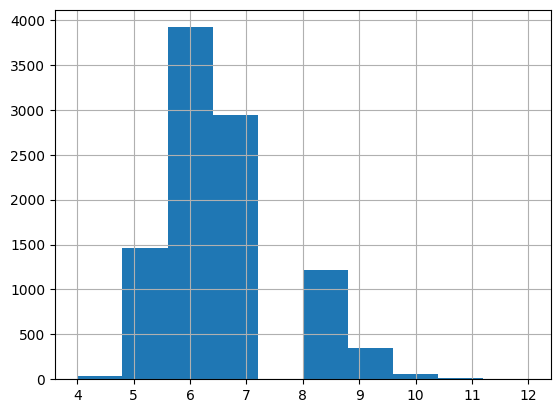

In [3]:
import pandas as pd
def get_max_degree(G):
  return max(G.degree(), key=lambda x: x[1])[1]
((pd.DataFrame(dataset_k5)[pd.DataFrame(dataset_k5)[1]==1][0]).apply(get_max_degree)).hist()

<Axes: >

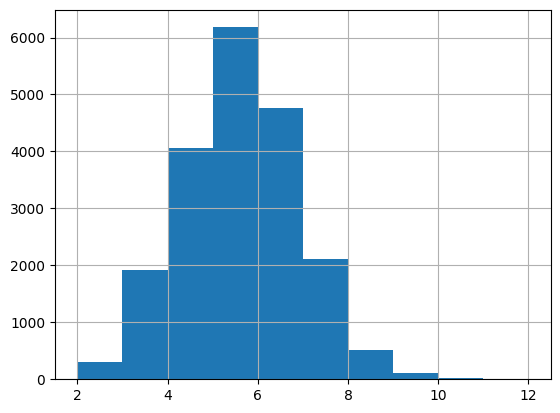

In [4]:
((pd.DataFrame(dataset_k5)[pd.DataFrame(dataset_k5)[1]==0][0]).apply(get_max_degree)).hist()

True

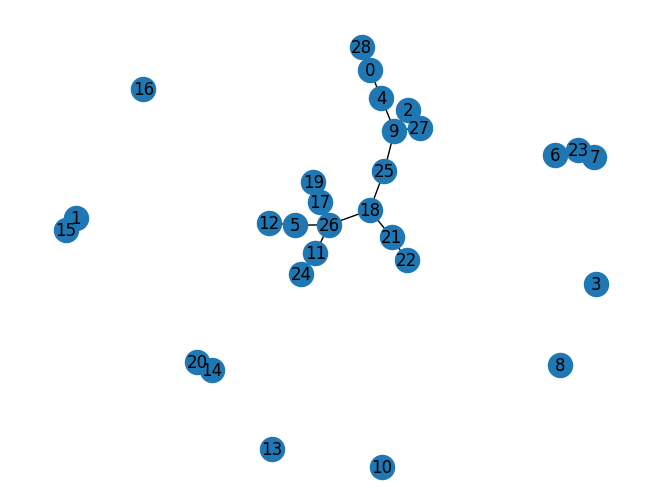

In [5]:
graph = pd.DataFrame(dataset_k5)[pd.DataFrame(dataset_k5)[1]==0].sample(1)[0].item()
nx.draw(graph, with_labels=True)
nx.is_planar(graph)

## Data Preprocessing
The following code preprocesses the data into PyGeometric format

In [6]:
from torch_geometric.data import Data
import torch
def networkx_to_pyg_graph(G, label, num_random_features=0):
    # Convert NetworkX graph to PyTorch Geometric graph
    edge_index = torch.tensor(list(map(list, zip(*list(G.edges)))), dtype=torch.long)
    x = torch.tensor([[G.degree(node)] + [random.uniform(0,10) for i in range(num_random_features)]  for node in G.nodes()], dtype=torch.float)
    # Adjust this part as per your specific node features

    y = torch.tensor([label], dtype=torch.float)

    data = Data(x=x, edge_index=edge_index.t().T, y=y)
    return data
num_random_features = 4 # we use 1 degree feature and 4 random numbers
pyg_dataset_k5 = [networkx_to_pyg_graph(graph, label, num_random_features) for graph, label in dataset_k5]
pyg_dataset_k33 = [networkx_to_pyg_graph(graph, label, num_random_features) for graph, label in dataset_k33]


## Model

The following is the basic MPNN model

In [7]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool

class MPNN(MessagePassing):
    def __init__(self, node_features, out_features, global_pooling = global_max_pool):
        super(MPNN, self).__init__(aggr='add')
        self.global_pooling = global_pooling
        self.lin = torch.nn.Linear(node_features, out_features)
        # self.lin2 = torch.nn.Linear(10, out_features)

    def forward(self, x, edge_index, batch):
        # Start propagating messages
        x = self.propagate(edge_index, x=x)
        x = self.global_pooling(x, batch)  # Aggregate features from all nodes
        # x = F.relu(self.lin(x))
        x = F.sigmoid(self.lin(x))

        return x

    def message(self, x_j):
        return x_j

## Model Trainer and Evaluater

The following is the code for training and validating the model

In [8]:
from torch_geometric.data import DataLoader
from torch.utils.data import random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
import numpy as np
# Training
from torch.optim import Adam
import torch
# Assume pyg_dataset is your complete dataset
train_size = int(0.8 * len(pyg_dataset_k5))  # 80% for training
val_size = len(pyg_dataset_k5) - train_size  # 20% for validation

def train(model, optimizer, criterion, train_loader):
    model.train()
    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        out = out.flatten()
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

labels = None
prediction = None

def evaludate(model, optimizer, criterion, val_loader, classification_threadold = 0.5):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for data in val_loader:
            out = model(data.x, data.edge_index, data.batch)
            out = out.flatten()
            loss = criterion(out, data.y)
            total_loss += loss.item()

            # Convert model outputs and labels to binary predictions and actual labels
            predictions = out >= classification_threadold
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())

    # Convert to numpy arrays for metrics calculation
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    global labels, prediction
    labels = all_labels
    prediction = all_predictions

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)

    return total_loss / len(val_loader), accuracy, precision, recall
def train_and_get_scores(model, optimizer, criterion, train_loader, val_loader, num_epoches = 50, verbose= True):
  accuracies = []
  precisions = []
  recalls = []
  # Training
  for epoch in range(num_epoches):  # Number of epochs
      train_loss = train(model, optimizer, criterion, train_loader)
      val_loss, val_accuracy, val_precision, val_recall = evaludate(model, optimizer, criterion, val_loader)
      accuracies.append(val_accuracy)
      precisions.append(val_precision)
      recalls.append(val_recall)
      if verbose:
        print(f'Epoch {epoch+1}, Training Loss: {train_loss:.4f}, '
              f'Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, '
              f'Precision: {val_precision:.4f}, Recall: {val_recall:.4f}')
  return accuracies, precisions, recalls


In [9]:
batch_size = 32
train_dataset_k5, val_dataset_k5 = random_split(pyg_dataset_k5, [train_size, val_size])

train_loader_k5 = DataLoader(train_dataset_k5, batch_size=batch_size, shuffle=True)
val_loader_k5 = DataLoader(val_dataset_k5, batch_size=batch_size, shuffle=False)
criterion = torch.nn.BCELoss()
model_k5_max_pool = MPNN(node_features=1+num_random_features, out_features=1)  # Adjust as needed
optimizer = Adam(model_k5_max_pool.parameters(), lr=0.001)
k5_a_max, k5_p_max, k5_r_max = train_and_get_scores(model_k5_max_pool, optimizer, criterion, train_loader_k5, val_loader_k5);

Epoch 1, Training Loss: 1.0408, Validation Loss: 0.6232, Accuracy: 0.6872, Precision: 0.5087, Recall: 0.5361
Epoch 2, Training Loss: 0.4790, Validation Loss: 0.3944, Accuracy: 0.8262, Precision: 0.7196, Recall: 0.7448
Epoch 3, Training Loss: 0.3721, Validation Loss: 0.3496, Accuracy: 0.8513, Precision: 0.7629, Recall: 0.7741
Epoch 4, Training Loss: 0.3482, Validation Loss: 0.3386, Accuracy: 0.8577, Precision: 0.7529, Recall: 0.8237
Epoch 5, Training Loss: 0.3377, Validation Loss: 0.3252, Accuracy: 0.8627, Precision: 0.7925, Recall: 0.7709
Epoch 6, Training Loss: 0.3300, Validation Loss: 0.3212, Accuracy: 0.8643, Precision: 0.7652, Recall: 0.8285
Epoch 7, Training Loss: 0.3226, Validation Loss: 0.3118, Accuracy: 0.8702, Precision: 0.7889, Recall: 0.8091
Epoch 8, Training Loss: 0.3171, Validation Loss: 0.3091, Accuracy: 0.8715, Precision: 0.7752, Recall: 0.8405
Epoch 9, Training Loss: 0.3112, Validation Loss: 0.3005, Accuracy: 0.8745, Precision: 0.8061, Recall: 0.7981
Epoch 10, Training 

In [10]:
model_k5_mean_pool = MPNN(node_features=1+num_random_features, out_features=1, global_pooling = global_mean_pool)  # Adjust as needed
optimizer = Adam(model_k5_mean_pool.parameters(), lr=0.001)
k5_a_mean, k5_p_mean, k5_r_mean = train_and_get_scores(model_k5_mean_pool, optimizer, criterion, train_loader_k5, val_loader_k5)

Epoch 1, Training Loss: 0.6091, Validation Loss: 0.5639, Accuracy: 0.7140, Precision: 0.6361, Recall: 0.2395
Epoch 2, Training Loss: 0.5581, Validation Loss: 0.5282, Accuracy: 0.7415, Precision: 0.6785, Recall: 0.3588
Epoch 3, Training Loss: 0.5305, Validation Loss: 0.5082, Accuracy: 0.7457, Precision: 0.6824, Recall: 0.3776
Epoch 4, Training Loss: 0.5159, Validation Loss: 0.4994, Accuracy: 0.7528, Precision: 0.6641, Recall: 0.4540
Epoch 5, Training Loss: 0.5077, Validation Loss: 0.4920, Accuracy: 0.7500, Precision: 0.6640, Recall: 0.4362
Epoch 6, Training Loss: 0.5028, Validation Loss: 0.4885, Accuracy: 0.7510, Precision: 0.6610, Recall: 0.4487
Epoch 7, Training Loss: 0.5004, Validation Loss: 0.4864, Accuracy: 0.7527, Precision: 0.6574, Recall: 0.4676
Epoch 8, Training Loss: 0.4982, Validation Loss: 0.4844, Accuracy: 0.7510, Precision: 0.6628, Recall: 0.4451
Epoch 9, Training Loss: 0.4973, Validation Loss: 0.4842, Accuracy: 0.7525, Precision: 0.6509, Recall: 0.4817
Epoch 10, Training 

In [11]:
# Training
batch_size = 32
train_dataset_k33, val_dataset_k33 = random_split(pyg_dataset_k33, [train_size, val_size])
train_loader_k33 = DataLoader(train_dataset_k33, batch_size=batch_size, shuffle=True)
val_loader_k33 = DataLoader(val_dataset_k33, batch_size=batch_size, shuffle=False)
model_k33_max_pool = MPNN(node_features=1+num_random_features, out_features=1)  # Adjust as needed
optimizer = Adam(model_k33_max_pool.parameters(), lr=0.001)
k33_a_max, k33_p_max, k33_r_max = train_and_get_scores(model_k33_max_pool, optimizer, criterion, train_loader_k33, val_loader_k33);

Epoch 1, Training Loss: 1.1698, Validation Loss: 0.8832, Accuracy: 0.5665, Precision: 0.2930, Recall: 0.2310
Epoch 2, Training Loss: 0.7609, Validation Loss: 0.6721, Accuracy: 0.6208, Precision: 0.2895, Recall: 0.1101
Epoch 3, Training Loss: 0.6474, Validation Loss: 0.6297, Accuracy: 0.6713, Precision: 0.0769, Recall: 0.0005
Epoch 4, Training Loss: 0.6340, Validation Loss: 0.6263, Accuracy: 0.6728, Precision: 0.0000, Recall: 0.0000
Epoch 5, Training Loss: 0.6331, Validation Loss: 0.6273, Accuracy: 0.6707, Precision: 0.0000, Recall: 0.0000
Epoch 6, Training Loss: 0.6330, Validation Loss: 0.6267, Accuracy: 0.6707, Precision: 0.0000, Recall: 0.0000
Epoch 7, Training Loss: 0.6335, Validation Loss: 0.6277, Accuracy: 0.6730, Precision: 0.0000, Recall: 0.0000
Epoch 8, Training Loss: 0.6332, Validation Loss: 0.6257, Accuracy: 0.6725, Precision: 0.0000, Recall: 0.0000
Epoch 9, Training Loss: 0.6331, Validation Loss: 0.6257, Accuracy: 0.6723, Precision: 0.0000, Recall: 0.0000
Epoch 10, Training 

In [12]:
model_k33_mean_pool = MPNN(node_features=1+num_random_features, out_features=1)  # Adjust as needed
optimizer = Adam(model_k33_mean_pool.parameters(), lr=0.001)
k33_a_mean, k33_p_mean, k33_r_mean = train_and_get_scores(model_k33_mean_pool, optimizer, criterion, train_loader_k33, val_loader_k33);

Epoch 1, Training Loss: 2.6029, Validation Loss: 0.6478, Accuracy: 0.6192, Precision: 0.3000, Recall: 0.1239
Epoch 2, Training Loss: 0.6394, Validation Loss: 0.6297, Accuracy: 0.6485, Precision: 0.0195, Recall: 0.0015
Epoch 3, Training Loss: 0.6339, Validation Loss: 0.6276, Accuracy: 0.6570, Precision: 0.0000, Recall: 0.0000
Epoch 4, Training Loss: 0.6335, Validation Loss: 0.6300, Accuracy: 0.6405, Precision: 0.0000, Recall: 0.0000
Epoch 5, Training Loss: 0.6336, Validation Loss: 0.6312, Accuracy: 0.6367, Precision: 0.0000, Recall: 0.0000
Epoch 6, Training Loss: 0.6339, Validation Loss: 0.6281, Accuracy: 0.6523, Precision: 0.0000, Recall: 0.0000
Epoch 7, Training Loss: 0.6339, Validation Loss: 0.6286, Accuracy: 0.6533, Precision: 0.0000, Recall: 0.0000
Epoch 8, Training Loss: 0.6334, Validation Loss: 0.6266, Accuracy: 0.6660, Precision: 0.0000, Recall: 0.0000
Epoch 9, Training Loss: 0.6332, Validation Loss: 0.6265, Accuracy: 0.6670, Precision: 0.0000, Recall: 0.0000
Epoch 10, Training 

## Result Visualization

In [13]:
k5_f1_max = [k5_p_max[i]*k5_r_max[i]*2/(k5_p_max[i]+k5_r_max[i]) for i in range(len(k5_r_max))]
k5_f1_mean = [k5_p_mean[i]*k5_r_mean[i]*2/(k5_p_mean[i]+k5_r_mean[i]) for i in range(len(k5_r_max))]
df_k5 = pd.DataFrame({'Score':k5_a_max+k5_f1_max+k5_a_mean+k5_f1_mean,
                      'Model':["Max Pooling"]*100+["Mean Pooling"]*100,
                      'Metric':["Accuracy"]*50+["F1 Score"]*50+["Accuracy"]*50+["F1 Score"]*50,
                      'Epochs':[i+1 for i in list(range(50))+list(range(50))+list(range(50))+list(range(50))]})
df_k5

,Score,Model,Metric,Epochs
0,0.687167,Max Pooling,Accuracy,1
1,0.826167,Max Pooling,Accuracy,2
2,0.851333,Max Pooling,Accuracy,3
3,0.857667,Max Pooling,Accuracy,4
4,0.862667,Max Pooling,Accuracy,5
...,...,...,...,...
195,0.552875,Mean Pooling,F1 Score,46
196,0.554203,Mean Pooling,F1 Score,47
197,0.544512,Mean Pooling,F1 Score,48
198,0.536813,Mean Pooling,F1 Score,49


In [14]:
import altair as alt
import pandas as pd

# Creating the line chart
chart = alt.Chart(df_k5).mark_line().encode(
    x='Epochs:Q',
    y='Score:Q',
    color='Model:N',
    strokeDash='Metric:N'
).properties(
    title=alt.TitleParams('Performance of K5 Model Over Epochs', fontSize=15)
).configure_axis(
    labelFontSize=12,
    titleFontSize=15
).configure_legend(
    labelFontSize=12,
    titleFontSize=15
)


chart


alt.Chart(...)

In [15]:
k33_f1_max = [k33_p_max[i]*k33_r_max[i]*2/(k33_p_max[i]+k33_r_max[i]) for i in range(len(k5_r_max))]
k33_f1_mean = [k33_p_mean[i]*k33_r_mean[i]*2/(k33_p_mean[i]+k33_r_mean[i]) for i in range(len(k5_r_max))]
df_k33 = pd.DataFrame({'Score':k33_a_max+k33_f1_max+k33_a_mean+k33_f1_mean,
                      'Model':["Max Pooling"]*100+["Mean Pooling"]*100,
                      'Metric':["Accuracy"]*50+["F1 Score"]*50+["Accuracy"]*50+["F1 Score"]*50,
                      'Epochs':[i+1 for i in list(range(50))+list(range(50))+list(range(50))+list(range(50))]}).fillna(0)
df_k33

,Score,Model,Metric,Epochs
0,0.566500,Max Pooling,Accuracy,1
1,0.620833,Max Pooling,Accuracy,2
2,0.671333,Max Pooling,Accuracy,3
3,0.672833,Max Pooling,Accuracy,4
4,0.670667,Max Pooling,Accuracy,5
...,...,...,...,...
195,0.000000,Mean Pooling,F1 Score,46
196,0.000000,Mean Pooling,F1 Score,47
197,0.000000,Mean Pooling,F1 Score,48
198,0.000000,Mean Pooling,F1 Score,49


In [16]:
# Creating the line chart
chart_k33 = alt.Chart(df_k33).mark_line().encode(
    x='Epochs:Q',
    y=alt.Y('Score:Q', scale=alt.Scale(domain=[0, 1])),
    color='Model:N',
    strokeDash='Metric:N'
).properties(
    title=alt.TitleParams('Performance of K3,3 Model Over Epochs', fontSize=15)
).configure_axis(
    labelFontSize=12,
    titleFontSize=15
).configure_legend(
    labelFontSize=12,
    titleFontSize=15
)

chart_k33

alt.Chart(...)

In [17]:
data = train_dataset_k33[145]
model_k5_max_pool(data.x, data.edge_index, data.batch)[0], data.y

(tensor([0.3027], grad_fn=<SelectBackward0>), tensor([0.]))

The following plot illustrates how well the two classes were seperated. K5 seems to be separated.

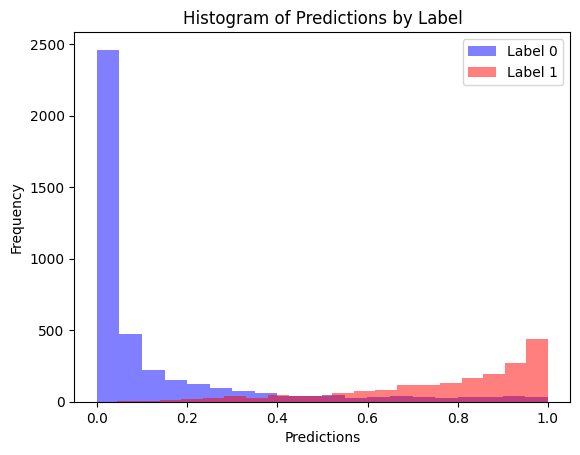

In [18]:
predictions = []
labels = []

for data in val_dataset_k5:
  predictions.append(model_k5_max_pool(data.x, data.edge_index, data.batch)[0].detach().numpy()[0])
  labels.append(data.y.detach().numpy()[0])
df = pd.DataFrame({'pred':predictions,'target':labels})
# Plotting
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'predictions' and 'labels' are lists or arrays you have
df = pd.DataFrame({'pred': predictions, 'target': labels})

# Plotting
fig, ax = plt.subplots()

# Histogram for label 0
ax.hist(df[df['target'] == 0]['pred'], bins=20, alpha=0.5, color='blue', label='Label 0')

# Histogram for label 1
ax.hist(df[df['target'] == 1]['pred'], bins=20, alpha=0.5, color='red', label='Label 1')

# Add labels, title, and legend
ax.set_xlabel('Predictions')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Predictions by Label')
ax.legend()

plt.show()

k33 is not well separated

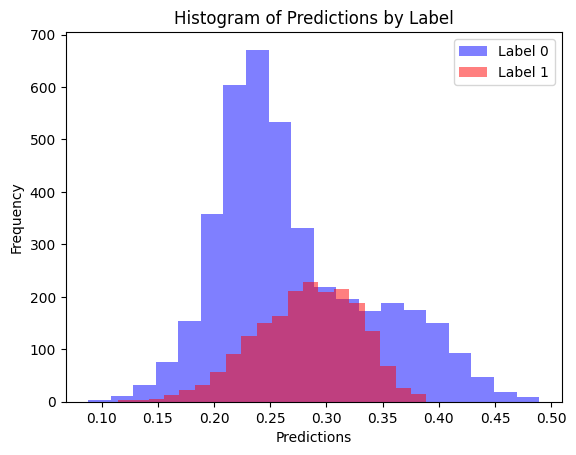

In [19]:
predictions = []
labels = []

for data in val_dataset_k33:
  predictions.append(model_k33_max_pool(data.x, data.edge_index, data.batch)[0].detach().numpy()[0])
  labels.append(data.y.detach().numpy()[0])
df = pd.DataFrame({'pred':predictions,'target':labels})
# Plotting

# Assuming 'predictions' and 'labels' are lists or arrays you have
df = pd.DataFrame({'pred': predictions, 'target': labels})

# Plotting
fig, ax = plt.subplots()

# Histogram for label 0
ax.hist(df[df['target'] == 0]['pred'], bins=20, alpha=0.5, color='blue', label='Label 0')

# Histogram for label 1
ax.hist(df[df['target'] == 1]['pred'], bins=20, alpha=0.5, color='red', label='Label 1')

# Add labels, title, and legend
ax.set_xlabel('Predictions')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Predictions by Label')
ax.legend()

plt.show()

Non planar graph has high chance of detecting

In [20]:
res = []
for i in range(10000):
  data = networkx_to_pyg_graph(generate_planar_graph(), 0, num_random_features)
  res.append((model_k5_max_pool(data.x, data.edge_index, data.batch))[0][0]>0.5)
1-sum(res)/10000

tensor(0.9791)

## Edge Example: Star Graphs

 The following code shows that star with max degree of 30 is incorrectly determined to contain K5

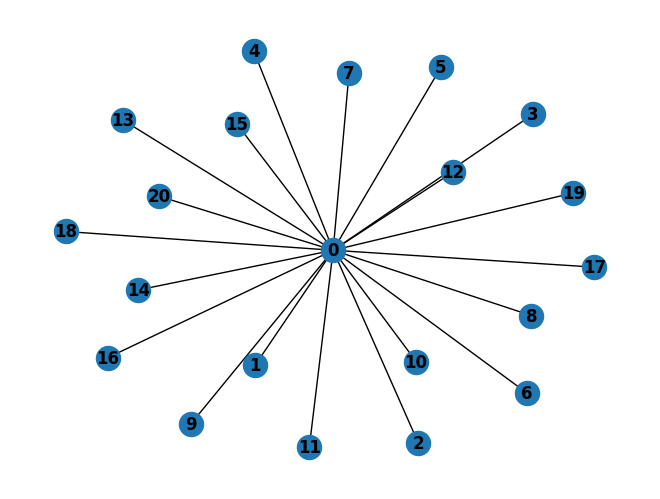

In [21]:
nx.draw(nx.star_graph(20), with_labels=True, font_weight='bold')


In [22]:
data = networkx_to_pyg_graph(nx.star_graph(20),0, num_random_features)
model_k5_max_pool(data.x, data.edge_index, data.batch)

tensor([[0.9966]], grad_fn=<SigmoidBackward0>)

We reconstruct the data set to include star graphs

In [23]:
num_graphs = 20000
dataset_k5_with_star = []

for _ in range(num_graphs // 2):
    v = random.randint(10, 30)
    graph_k5 = generate_graph_with_k5(num_extra_nodes=v, num_extra_edges=int(random.uniform(0.5, 1.5)*v))
    graph_k33 = generate_graph_with_k33(num_extra_nodes=v, num_extra_edges=int(random.uniform(0.5, 1.5)*v))
    dataset_k5_with_star.append((graph_k5, 1))  # Label 1 for graphs containing K5
    dataset_k5_with_star.append((generate_graph_with_k5(num_extra_nodes=v, num_extra_edges=int(random.uniform(0.5, 1.5)*v)), 1))
    dataset_k5_with_star.append((nx.star_graph(v), 0)) # star graphs 10 to 30!!


for _ in range(num_graphs // 2):
    v = random.randint(10, 30)
    graph = generate_planar_graph(v,int(random.uniform(0.5, 1.5)*v))
    dataset_k5_with_star.append((graph, 0))  # Label 0 for graphs not containing K5


In [24]:
pyg_dataset_k5_with_star = [networkx_to_pyg_graph(graph, label, num_random_features) for graph, label in dataset_k5_with_star]

In [25]:
batch_size = 32
train_size = int(0.8 * len(pyg_dataset_k5_with_star))  # 80% for training
val_size = len(pyg_dataset_k5_with_star) - train_size  # 20% for validation
train_dataset_k5, val_dataset_k5 = random_split(pyg_dataset_k5_with_star, [train_size, val_size])

train_loader_k5 = DataLoader(train_dataset_k5, batch_size=batch_size, shuffle=True)
val_loader_k5 = DataLoader(val_dataset_k5, batch_size=batch_size, shuffle=False)
criterion = torch.nn.BCELoss()
model_k5_max_pool = MPNN(node_features=1+num_random_features, out_features=1)  # Adjust as needed
optimizer = Adam(model_k5_max_pool.parameters(), lr=0.001)
k5_a_max, k5_p_max, k5_r_max = train_and_get_scores(model_k5_max_pool, optimizer, criterion, train_loader_k5, val_loader_k5);

Epoch 1, Training Loss: 1.4715, Validation Loss: 0.7099, Accuracy: 0.5995, Precision: 0.5869, Recall: 0.6985
Epoch 2, Training Loss: 0.6211, Validation Loss: 0.5795, Accuracy: 0.7629, Precision: 0.6828, Recall: 0.9908
Epoch 3, Training Loss: 0.5565, Validation Loss: 0.5355, Accuracy: 0.8136, Precision: 0.7305, Recall: 0.9998
Epoch 4, Training Loss: 0.5164, Validation Loss: 0.4989, Accuracy: 0.8425, Precision: 0.7624, Recall: 0.9998
Epoch 5, Training Loss: 0.4819, Validation Loss: 0.4677, Accuracy: 0.8599, Precision: 0.7842, Recall: 0.9968
Epoch 6, Training Loss: 0.4531, Validation Loss: 0.4452, Accuracy: 0.8824, Precision: 0.8267, Recall: 0.9705
Epoch 7, Training Loss: 0.4294, Validation Loss: 0.4206, Accuracy: 0.8834, Precision: 0.8154, Recall: 0.9941
Epoch 8, Training Loss: 0.4100, Validation Loss: 0.4022, Accuracy: 0.8959, Precision: 0.8352, Recall: 0.9889
Epoch 9, Training Loss: 0.3935, Validation Loss: 0.3906, Accuracy: 0.8886, Precision: 0.8226, Recall: 0.9938
Epoch 10, Training 

Including stars in the data set helps to recognize this category.

In [26]:
data = networkx_to_pyg_graph(nx.star_graph(20),0, num_random_features)
model_k5_max_pool(data.x, data.edge_index, data.batch)

tensor([[0.0478]], grad_fn=<SigmoidBackward0>)